# Как научить компьютер читать? 

Это третья, заключительная, часть большой открытой лекции "Как научить компьютер читать?" В ней мы обучим на твиттах нейросетку, которая умеет отличать позитив от негатива. А также немного поглазеем на новости.

# 1. Анализ тональности общественного мнения

Давайте попробуем сделать что-нибудь прикольное! Например, проанализировать общественное мнение по поводу чего-нибудь. Одним из способов анализа общественного мнения является анализ тональности Twitter по нескольким релевантным хэштегам. Например, вот в [этой статье на Хабре](https://habr.com/company/dca/blog/274027/) пацаны пытались проанализировать динамику общественного мнения о новом эпизоде звёздных войн. 

Попробуем сделать что-то похожее. Для этого возьмём из интернета [готовую разметку твиттера](http://study.mokoron.com) на положительный и отрицательный сентимент-окрас твиттов. Свой анализатор тональности будем пилить с помощью простенькой рекурентной нейронной сетки. На самом деле обычная логистическая регрессия даст на выходе точно такой же результат в плане точности из-за того, что данных для обучения у нас не так уж и много. Тем не менее, тема лекции: нейронные сети. Поэтому именно их мы и будем пилить. 

Для начала подгрузим кучу пакетов и немного предобработаем данные.

## 1.1 Предобработка данных

In [2]:
import pandas as pd  # для таблиц
import numpy as np   # для матриц

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import re # библиотека для регулярных выражений

# лемматизатор
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# список стоп-слов
import nltk.corpus
stopwords = set([word for word in nltk.corpus.stopwords.words('russian') if word != 'не'])

# удобный словарь
from collections import defaultdict

# слои для нейронок, которые нам пригодятся 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [3]:
df_neg = pd.read_csv('negative.csv', sep=';',header=-1)
df_pos = pd.read_csv('positive.csv', sep=';',header=-1)

df = df_pos[[3,4]].append(df_neg[[3,4]])
df.columns = ['text', 'target']
df.reset_index(drop=True, inplace=True)
df.target = df.target.replace({-1:0})

print(df.shape)
df.head()

FileNotFoundError: File b'negative.csv' does not exist

В первом столбце тексты твиттов. Во втором столбце две метки: либо $1$, если твит позитивный, либо $0$, если твит негативный.

In [1]:
df.text.iloc[10]  # пример позитива

NameError: name 'df' is not defined

In [4]:
df.text.iloc[-10] # пример негатива

'@ivanenko14 и у меня также, только будильник еще и не выключался.. папу разбудила ('

Займёмся предобработкой текстов. 

* очистим их от мусорных символов
* лемматиизируем
* выбросим стоп-слова 

In [5]:
text = df.text[0] 
words = [morph.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 2) and (word not in stopwords)]

' '.join(words)

'first timee школотый поверь самый общество профилировать предмет тип'

Оборачиваем предобработчик в приятную функцию и применяем его ко всей таблице.

In [6]:
def prepare_text(text):  
    words = [morph.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 2) and (word not in stopwords)]
    return words

In [7]:
%%time
df['prepare_text'] = df.text.apply(prepare_text)

CPU times: user 6min 12s, sys: 2.73 s, total: 6min 14s
Wall time: 6min 17s


In [8]:
df.head()

,text,target,prepare_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,"[first, timee, школотый, поверь, самый, общест..."
1,"Да, все-таки он немного похож на него. Но мой ...",1,"[таки, немного, похожий, мальчик, равно]"
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,"[rt, katiacheh, идиотка, испугаться]"
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,"[rt, digger2912, угол, сидеть, погибать, голод..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1,"[irina, dyshkant, значит, страшилка, блин, пос..."


Найдём самые часто встречающиеся слова. Заменим все одинаковые слова на числовые коды. 

In [9]:
words_count = defaultdict(lambda: 0)

for text in df.prepare_text:
    for word in text:
        words_count[word] +=1
        
len(words_count)

211494

In [10]:
top_words = 24999    # ограниичимся словарём из 25000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

df['freq_text'] = df.prepare_text.apply(freq_filter)
df.head()

,text,target,prepare_text,freq_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,"[first, timee, школотый, поверь, самый, общест...","[19125, 24222, 9648, 3030, 7768, 5413, 5567]"
1,"Да, все-таки он немного похож на него. Но мой ...",1,"[таки, немного, похожий, мальчик, равно]","[16540, 16329, 2898, 17312, 10337]"
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,"[rt, katiacheh, идиотка, испугаться]","[11078, 6465, 237]"
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,"[rt, digger2912, угол, сидеть, погибать, голод...","[11078, 3028, 16154, 1258, 12744, 7456, 19116,..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1,"[irina, dyshkant, значит, страшилка, блин, пос...","[10572, 20859, 4576, 8448, 8857, 17521, 15998,..."


In [11]:
df.freq_text.apply(len).hist()

In [12]:
dff = df[df.freq_text.apply(len) > 2] # Выбрасываем из обучения все посты короче 3-х слов.

In [13]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.freq_text.get_values(), df.target.get_values(), test_size=0.2)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# как выглядит вектор
X_train[0][:20]

181467 train sequences
45367 test sequences


array([ 7265,  2012, 24257, 18975, 14927,  6751,  9281, 10952,  3059,
       16338,  5053,  5790, 20550])

Разные тексты - разной длины. Нам в нашу сетку хотелось бы посылать последовательности одинаковой длины. Обрежем все длиные посты до $20$ слов. Если в посте меньше $20$ слов, дополним его слева нулями.

In [15]:
max_twitter_length = 20         # обрежем все посты до 20 слов

X_train = sequence.pad_sequences(X_train, maxlen=max_twitter_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_twitter_length)

In [16]:
X_train[0][:20]

array([    0,     0,     0,     0,     0,     0,     0,  7265,  2012,
       24257, 18975, 14927,  6751,  9281, 10952,  3059, 16338,  5053,
        5790, 20550], dtype=int32)

## 1.2 Собираем нейросети

Попробуем обучить несколько разных малокалиберных нейросеток. 


<img align="center" src="arh_1.png" width="400">


In [17]:
embedding_vector_length = 64    # размерность эмбендинга
top = top_words + 1             # на вход идут слова и нулевой элемент

In [18]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_twitter_length))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# собираем сетку и выбираем оптимизатор для обучения
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
%%time 
# гоняем сетку три эпохи
hist = model.fit(X_train, y_train, validation_split=0.15, epochs=3, batch_size=32)

Train on 154246 samples, validate on 27221 samples
Epoch 1/3
154246/154246 [==============================] - 112s 725us/step - loss: 0.5578 - acc: 0.7111 - val_loss: 0.5231 - val_acc: 0.7370
Epoch 2/3
154246/154246 [==============================] - 114s 739us/step - loss: 0.4758 - acc: 0.7723 - val_loss: 0.5217 - val_acc: 0.7433
Epoch 3/3
154246/154246 [==============================] - 111s 722us/step - loss: 0.4330 - acc: 0.7977 - val_loss: 0.5338 - val_acc: 0.7263
CPU times: user 14min 23s, sys: 5min 32s, total: 19min 55s
Wall time: 5min 38s


In [20]:
# качество на тесте
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.7304


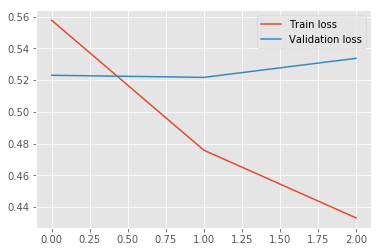

In [24]:
# когда начали переобучаться
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 8)             1544      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 8)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,606,825
Trainable params: 1,606,825
Non-trainable params: 0
_________________________________________________________________


Видим, что почти сразу мы начинаем переобучаться. Оно и не удивительно. Выборка довольно маленькая. Попробуем ввести дополнительный слой дропаута для регуляризации, а также немного облечим архитектуру.


<img align="center" src="arh_2.png" width="400">

In [26]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_twitter_length))
model.add(LSTM(1, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(1))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 64)            1600000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 1)             264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 1,600,278
Trainable params: 1,600,278
Non-trainable params: 0
_________________________________________________________________


In [30]:
%%time
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=32)

Train on 145173 samples, validate on 36294 samples
Epoch 1/3
145173/145173 [==============================] - 109s 750us/step - loss: 0.5627 - acc: 0.7089 - val_loss: 0.5223 - val_acc: 0.7419
Epoch 2/3
145173/145173 [==============================] - 105s 722us/step - loss: 0.4801 - acc: 0.7705 - val_loss: 0.5191 - val_acc: 0.7427
Epoch 3/3
145173/145173 [==============================] - 105s 721us/step - loss: 0.4379 - acc: 0.7975 - val_loss: 0.5169 - val_acc: 0.7439
CPU times: user 13min 47s, sys: 4min 16s, total: 18min 4s
Wall time: 5min 19s


In [31]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.7444


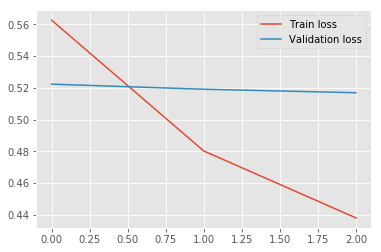

In [32]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

Мы немного уронили качество. Вернёмся к первой архитектуре. Будем учить сетку ровно одну эпоху.

In [33]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_twitter_length))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 64)            1600000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 8)             1544      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 8)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,602,097
Trainable params: 1,602,097
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=1, batch_size=32)

Train on 145173 samples, validate on 36294 samples
Epoch 1/1
145173/145173 [==============================] - 99s 680us/step - loss: 0.5637 - acc: 0.7054 - val_loss: 0.5248 - val_acc: 0.7364
CPU times: user 4min 36s, sys: 1min 14s, total: 5min 50s
Wall time: 1min 40s


In [35]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.7388


В принципе эксперименты можно ставить довольно долго. К сущесвенному улучшению качества это не приведёт. Для этого нужно растить выборку. Остановимся на последней архитектуре и перейдём к выбору порогов. Подберём два порога: для детекции позитива и детекции негатива. Всё, что между ними будем относить к нейтральному классу.

In [36]:
from sklearn.metrics import classification_report

cutoff = 0.65  # выбрали погог

# говорим, что все клиенты с вероятностью оттока больше 0.5 уйдут
y_hat = model.predict_proba(X_test) > cutoff

# выводим на экран отчёт, в которым посчитаются метрики по всем классам
report = classification_report(y_test, y_hat)
print(report)

             precision    recall  f1-score   support

          0       0.68      0.86      0.76     22476
          1       0.81      0.59      0.69     22891

avg / total       0.75      0.73      0.72     45367



В принципе, если мы подберём в качестве порога для негатива $0.65$, на тесте мы найдём $65\%$ позитивных коментов с точностью $80\%$.

In [37]:
cutoff = 0.45  # выбрали погог

# говорим, что все клиенты с вероятностью оттока больше 0.5 уйдут
y_hat = model.predict_proba(X_test) > cutoff

# выводим на экран отчёт, в которым посчитаются метрики по всем классам
report = classification_report(y_test, y_hat)
print(report)

             precision    recall  f1-score   support

          0       0.77      0.66      0.71     22476
          1       0.71      0.81      0.75     22891

avg / total       0.74      0.73      0.73     45367



Для негатива поставим порог $0.45$. По аналогии это поможет нам детектировать $61\%$ негатива с $80\%$ точностью. Всё, что находится между $0.45$ и $0.65$ будем считать нейтральным.

Можно было бы добавить в выборку нейтральные комментарии, которые нельзя по своей окраске отнести ни к одному из классов. Тогда бы мы учили сетку с несколькими выходами и решали бы к какому классу относится комментарии по самой большой вероятности. Перейдём к применению обученной сетки.

# 2. Применение на твиттере

Напишем функцию, которая будет считывать данные по твиттам на определённую тематику и строить для них прогнозы. Все твиты мы заблаговременно спарсили.

In [38]:
def table_prepare(path):

    df = pd.read_csv(path, sep='\t')
    df = df[['Tweets', 'Date']]

    # предобработали дату
    df.Date = df.Date.apply(lambda x: x.split(' ')[2] + ' ' 
                        + x.split(' ')[1] + ' ' + x.split(' ')[-1])

    # по очереди применяем все предобрабатывающие функции
    df['prepareTweets'] = df.Tweets.apply(prepare_text).apply(freq_filter)

    df = df[df.prepareTweets.apply(len) > 2] # Выбрасываем все посты короче 3-х слов.
    print("Размер таблицы: ", df.shape)
    # финальная предобработка (добавление нулей)
    X = sequence.pad_sequences(df.prepareTweets.values, maxlen=max_twitter_length)

    # предсказываем вероятность негатива
    prob = model.predict_proba(X)
    df['prob'] = prob
    return df[['Date', 'Tweets', 'prob']]

Также напишем небольшую функцию, которая будет наши данные агрегировать по дням и визуализировать.

In [85]:
def negative_plot(df):
    df['Negative'] = df.prob < 0.45
    df['Positive'] = df.prob > 0.65
    df['Neutral'] = (df.prob <= 0.65) | (df.prob >= 0.45)

    df_abs = df[['Date', 'Positive', 'Neutral','Negative']].groupby('Date').sum()
    df_perc = df_abs.divide(df_abs.sum(axis=1), axis=0)
    
    # строим красивую картинку 
    plt.figure(figsize=(14,6))

    # colors: https://www.color-hex.com/color/2ecc71
    pal = ["#e74c3c", "#f1c40f", "#2ecc71"]

    plt.stackplot(df_perc.index, df_perc['Negative'],  df_perc['Neutral'], df_perc['Positive'], 
                        labels=['Negative','Neutral','Positive'],  colors=pal)

    plt.legend(loc='lower right')
    plt.margins(0,0)
    plt.title('Доли твитов определённой тональности',size=18)
    plt.show()
    pass 

## 2.1 Что люди пишут в твиттере о кино?

In [86]:
df_rapsodia = table_prepare('df_film_rapsodia.csv')
df_rapsodia.head()

Размер таблицы:  (3996, 3)


,Date,Tweets,prob
0,23 Nov 2018,#ВечернийУргант. Богемская рапсодия 🔥 https://...,0.847609
3,27 Nov 2018,"""Богемская рапсодия""-прекрасный подбор актеров...",0.916440
4,27 Nov 2018,RT @assambleya: богемская рапсодия би лайк htt...,0.796588
5,27 Nov 2018,RT @drsy10WSbjZ3Sho: девочка: ой Богемская Рап...,0.635965
9,27 Nov 2018,Фух единственный тип который не ходил на фильм...,0.662984


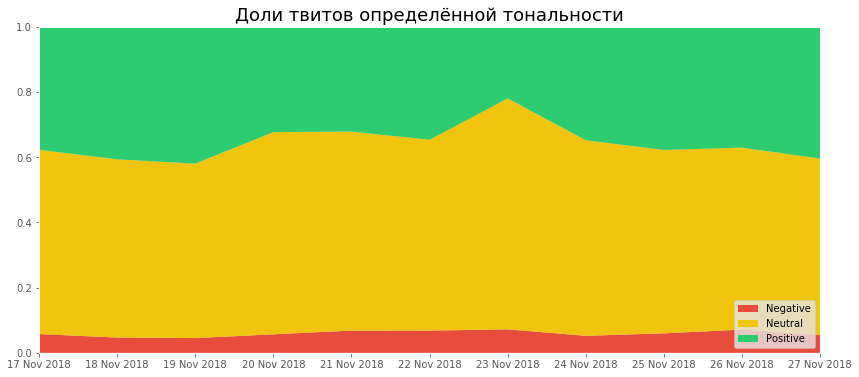

In [87]:
negative_plot(df_rapsodia)

In [88]:
df_fantastic = table_prepare('df_film_fantastic.csv')
df_fantastic.head()

Размер таблицы:  (11755, 3)


,Date,Tweets,prob
0,18 Nov 2018,"Интересно, включены ли в тест фантастические т...",0.575234
1,22 Nov 2018,Фантастические твари и сколько ещё они будут т...,0.376139
2,27 Nov 2018,RT @Chehovskyi: Фантастические твари и как они...,0.282820
3,27 Nov 2018,15 ноября при поддержке Европы Плюс в прокат в...,0.776797
4,27 Nov 2018,RT @metashot: 1918 год - издательство заказыва...,0.314818


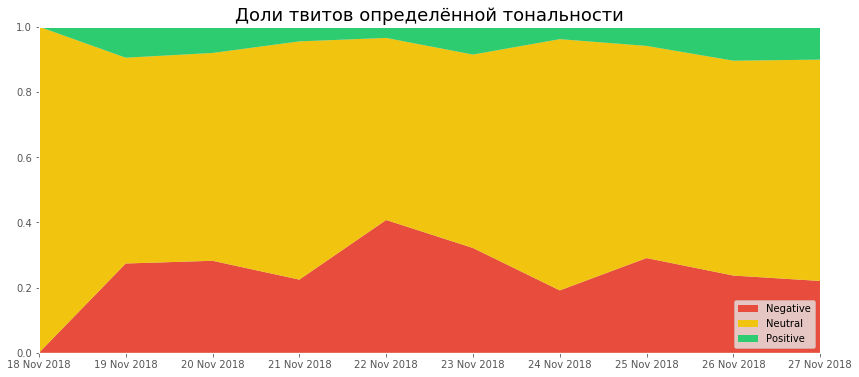

In [89]:
negative_plot(df_fantastic)

In [129]:
# пример позитива
df_fantastic[df_fantastic.prob > 0.9].Tweets.iloc[0]

'Фантастические твари и места их обитания. \nКак я ржу, боже, спасибо 😂😂 https://t.co/k2HYKW1Aln'

In [130]:
# пример негатива
df_fantastic[df_fantastic.prob < 0.1].Tweets.iloc[0]

'@odnostrochniki “Фантастические твари, и как же они сука заебали”'

## 2.2 Что люди пишут в твиттере о банках?

In [90]:
df_sber = table_prepare('df_sber.csv')
df_sber.head()

Размер таблицы:  (6980, 3)


,Date,Tweets,prob
0,27 Nov 2018,Сбербанк прокомментировал сообщения о блокиров...,0.690241
1,27 Nov 2018,Сбербанк уведомил Еврокомиссию об утечке персо...,0.820485
2,27 Nov 2018,RT @bloginmydreams: Сбербанк - рабовладелец му...,0.899656
3,27 Nov 2018,RT @bloginmydreams: Сбербанк - рабовладелец му...,0.899656
4,27 Nov 2018,"бля читал ""север против юга(Жюль Верн)"",про гр...",0.445979


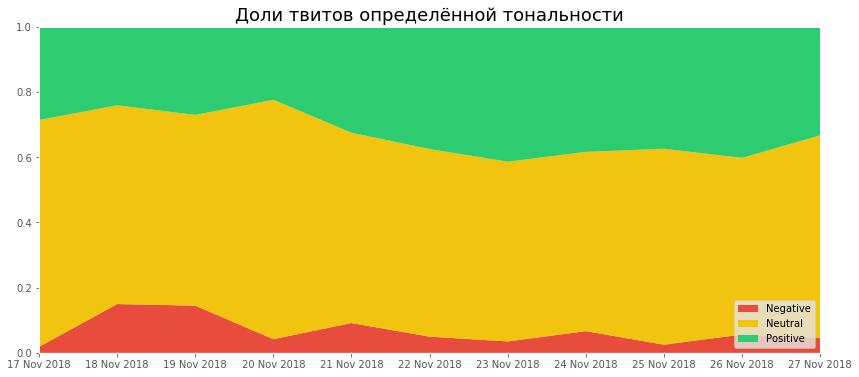

In [91]:
negative_plot(df_sber)

In [94]:
df_tinkoff = table_prepare('df_tinkoff.csv')
df_tinkoff.head()

Размер таблицы:  (2637, 3)


,Date,Tweets,prob
0,27 Nov 2018,RT @ru_thebell: Лучшими мобильными приложениям...,0.902840
1,27 Nov 2018,хочу помочь финансово хоть как-то но тинькофф ...,0.310151
2,27 Nov 2018,"RT @_U_R_I_c: Догадайтесь, у кого все хорошо?\...",0.898706
3,27 Nov 2018,Подравнять шмоньку в Бест Клиник можно было за...,0.849772
4,27 Nov 2018,@n_fonok @yoshkinkrot Враньё. Тинькофф и Сбер ...,0.603183


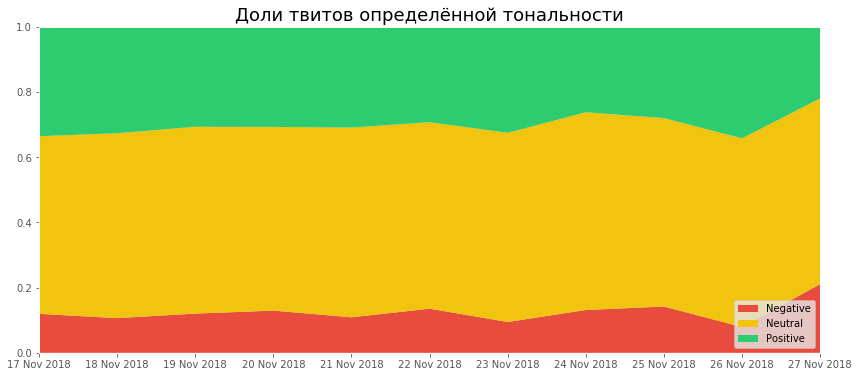

In [95]:
negative_plot(df_tinkoff)

## 2.3 Что люди думают о рэпе?

In [96]:
df_basta = table_prepare('df_basta.csv')
df_basta.head()

Размер таблицы:  (8142, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.940015
1,26 Nov 2018,"#ябудупетьсвоюмузыку\nААААА Баста, Нойз и Окси...",0.803054
2,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.745014
3,27 Nov 2018,"Мне понравилось видео ""Баста feat. Noize MC и ...",0.788779
4,27 Nov 2018,RT @norimyxxxo: Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБас...,0.677200


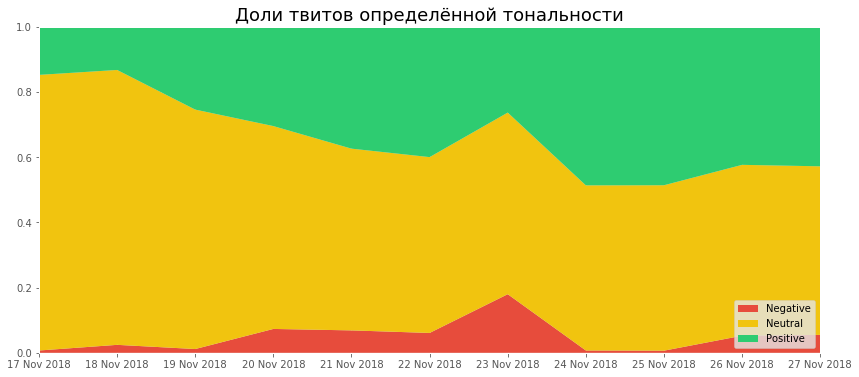

In [97]:
negative_plot(df_basta)

In [98]:
df_noize = table_prepare('df_noize.csv')
df_noize.head()

Размер таблицы:  (6856, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.940015
1,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.745014
2,24 Nov 2018,"Оксимирон, Баста и Noize MC проведут концерт в...",0.914421
3,27 Nov 2018,RT @KoleNikita: Чтобы вы понимали!\n\nНа одной...,0.443647
4,27 Nov 2018,"Музыка WG Fest 2018: Sabaton, «Звери» и Noize ...",0.924838


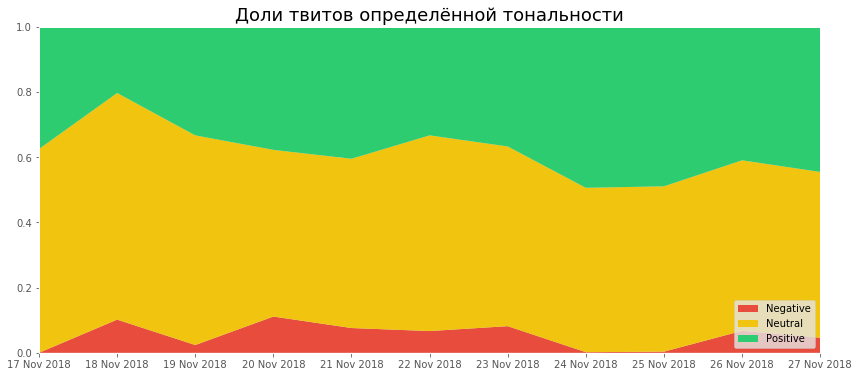

In [99]:
negative_plot(df_noize)

In [100]:
df_oxxy = table_prepare('df_oxxy.csv')
df_oxxy.head()

Размер таблицы:  (5379, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.940015
1,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.745014
2,24 Nov 2018,#ябудупетьсвоюмузыку\nКупил два билета на конц...,0.905536
3,27 Nov 2018,"Мне понравилось видео ""Баста feat. Noize MC и ...",0.788779
4,27 Nov 2018,RT @norimyxxxo: Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБас...,0.677200


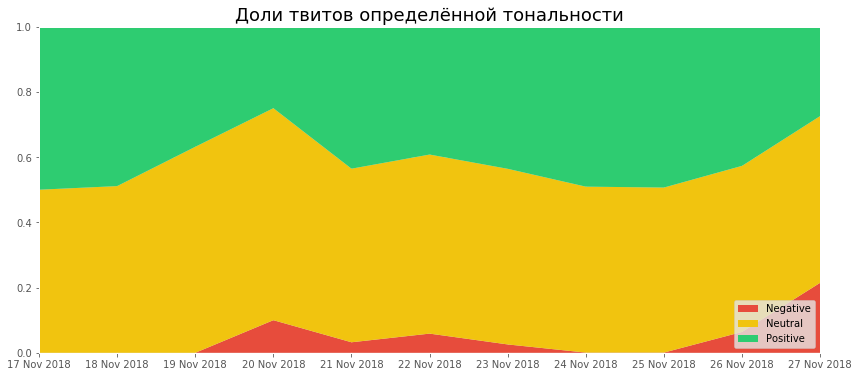

In [101]:
negative_plot(df_oxxy)

## 2.4 Ваши идеи

In [ ]:
df_you = table_prepare(' ')
df_you.head()

In [ ]:
negative_plot(df_you)

In [ ]:
df_you = table_prepare(' ')
df_you.head()

In [ ]:
negative_plot(df_you)

# 3 Применяем модель к новостным заголовкам

Давайте возьмём поток новостей за 2017 год и пройдёмся по его заголовкам нашим классификатором негатива и позитива. Интересно было бы узнать, что из себя представляют СМИ. На самом деле так делать нечестно, потому что мы учили нашу сетку на совершенно другой вид контента. Но ради интереса можно попробовать.

Выборка новостей собрана с сайта Тасс лично мной :) 

In [133]:
import pickle
with open('tass_news_2017.pickle', 'rb') as f:
     tass_news = pickle.load(f)

In [134]:
tass_news[0]

{'category': 'Спорт',
 'date': '2017-11-22 10:01:52',
 'href': '/sport/4748419',
 'text': 'тасс 22 ноябрь тасс международный олимпийский комитет мокнуть несправедливый наказать шестеро российский лыжник пожизненный отстранение олимпиада подозрение нарушение антидопинговый правило игра 2014 год сочи такой мнение высказать врач расмуса дамсгаард сотрудничать международный федерация лыжный спорт fis слово который приводить газета aftenposten ноябрь мокнуть пожизненно отстранить александр легкова евгений белов максим вылегжанин алексей петухов юлий иванов евгений шаповалов участие олимпиада аннулировать результат показать игра 2014 сочи нарушение антидопинговый правило допинг проба спортсмен найти запретить субстанция основание дисквалификация послужить царапина пробирка анализ лыжник олимпиада сочи однако отстранение спортсмен распространяться соревнование эгида fis организация принять отдельный решение дело россиянин поздний это грустно спортсмен отстранить быть виновный сказать дамсгаар

Вытащим даты и заголовки.

In [137]:
titles = [news['title'] for news in tass_news]
dates = [news['date'].split(' ')[0] for news in tass_news]
len(titles)

112445

Провернём над ними ровно тот же процесс предобработки, что и раньше.

In [140]:
df = pd.DataFrame( )
df['Date'] = dates
df['Titles'] = titles

# по очереди применяем все предобрабатывающие функции
df['prepareTitles'] = df.Titles.apply(prepare_text).apply(freq_filter)

# Выбрасываем все титулы короче 3-х слов.
df = df[df.prepareTitles.apply(len) > 2]

print("Размер таблицы: ", df.shape)
df.head()

Размер таблицы:  (110726, 3)


,Date,Titles,prepareTitles
0,2017-11-22,эксперт пожизненный отстранение российский лыж...,"[18654, 904, 20027, 23062, 14768, 13068]"
1,2017-03-31,источник володин направить половина свой доход...,"[3438, 17283, 21171, 21393, 764, 23898, 15695,..."
2,2017-07-17,лондонский страховщик оценить потенциальный ущ...,"[23322, 24906, 18743, 18927, 2419]"
3,2017-03-13,россиянин 2016 год оплатить карта товар услуга...,"[5103, 15695, 15956, 16551, 310, 12568, 7593, ..."
4,2017-11-13,комитет госдума одобрить увеличение финансиров...,"[6066, 16954, 12330, 12632, 9356, 4775, 13530,..."


In [141]:
# финальная предобработка (добавление нулей)
X = sequence.pad_sequences(df.prepareTitles.values, maxlen=max_twitter_length)

# предсказываем вероятность
prob = model.predict_proba(X)
df['prob'] = prob

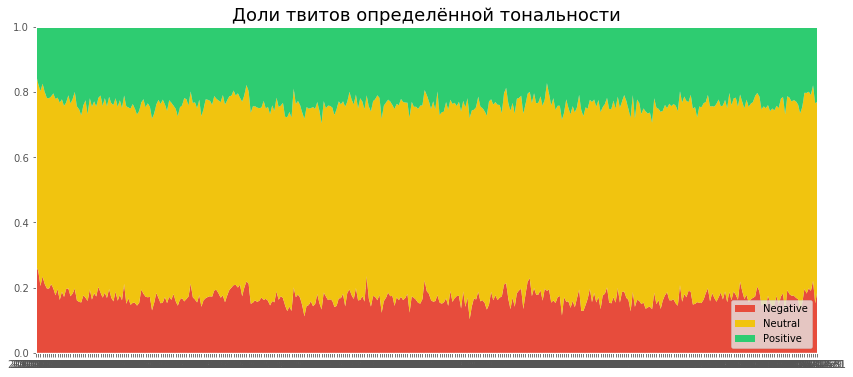

In [142]:
negative_plot(df)

In [159]:
df[df['prob'] > 0.95].Titles.iloc[0]

'депутат госдума представитель европа пора посетить крым говорить препятствие'

In [158]:
df[df['prob'] < 0.1].Titles.iloc[0]

'сми йемен 35 человек погибнуть результат удар ввс аравийский коалиция'

## Дополнительное чтиво: 

* [Статья про LSTM и звёздные войны.](https://habr.com/company/dca/blog/274027/) Пацаны сделали то же самое, что и мы, и их опубликовали в Известиях. А нас нет. Хочу, чтобы меня опубликовали в какой-нибудь крутой газете. Если вы журналист и хотите опубликовать меня, напишите мне. Да. 

* [Статья с хабра про w2v.](https://habr.com/company/ods/blog/329410/) Там есть пример работы с переходами по сайтам, по аналогии можно работать с транзакциями. 

* [Очень большой и неструктурированный код с рисёрчем по новостям с ленты.](https://github.com/Myonin/silentio.su/blob/master/topic_model_texts_lenta_ru.ipynb)
